In [30]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.stats
import seaborn as sns
import numpy as np

# import some data to play with
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target

In [31]:
# --------------------
# The EM algo
# --------------------

def normal_density(X, mu, Sigma):
    L = np.linalg.cholesky(Sigma)
    Linv = np.linalg.inv(L)
    Sinv = Linv.T.dot(Linv)
     
    XL = X.dot(Linv)
    # P stands for precision, i.e. inverse Sigma
    xPx = (XL*XL).sum(axis=1)
    xPmu = X.dot(Sinv).dot(mu)
    muPmu = mu.dot(Sinv).dot(mu)
    mahalanobis = xPx -2*xPmu + muPmu
    twoPiPowD = (2*np.pi)**D
    sqrtDetSigma = L.diagonal().prod()
    density = 1/(np.sqrt(twoPiPowD)*sqrtDetSigma)*np.exp(-0.5*(mahalanobis))
    return density

K = 2 # Cluster count
max_iter = 20
(N,D) = X.shape

# Initialize
mu = np.random.randn(K,D)
Sigma = np.zeros([K,D,D])
for k in range(K):
    #L = np.random.randn(D,D)
    Sigma[k,:,:] = np.eye(D) #+ L.dot(L.T)
cls_prob = np.zeros([N,K])
pi_k = np.ones(K)/K

list_log_lik = np.zeros([max_iter])

for iter in range(max_iter):

    # E-STEP ---------------------------------------------
    # Update cluster probabilities
    for k in range(K):
        cls_prob[:,k] = pi_k[k]*normal_density(X,mu[k,:],Sigma[k,:,:])
    cls_prob = cls_prob / np.broadcast_to(np.expand_dims(cls_prob.sum(axis=1), axis=1),(N,K))    
    
    Nk = cls_prob.sum(axis=0)
    pi_k = Nk / Nk.sum()
    
    # M-STEP ---------------------------------------------
    # Update means and covariances
    for k in range(K):
        clsProbMat = np.broadcast_to(np.expand_dims(cls_prob[:,k], axis=1),(N,D))
        mu[k,:] = 1/Nk[k]*(X*clsProbMat).sum(axis=0)
        
        Z = (X - mu[k,:])*np.sqrt(clsProbMat)
        ZtZ = 1/Nk[k]*Z.T.dot(Z)
        Sigma[k,:,:] = 1/Nk[k]*ZtZ + np.eye(D)
        
    # Report model fit ----------------
    evidence = 0
    for k in range(K):
        evidence += pi_k[k]*normal_density(X,mu[k,:],Sigma[k,:,:])
    list_log_lik[iter] = np.log(evidence).sum()
    


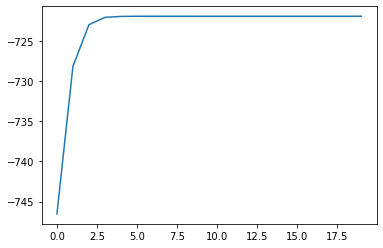

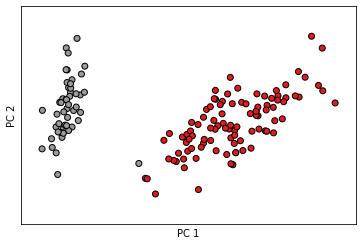

In [36]:
X_pca = PCA(n_components=2).fit_transform(iris.data)
y=np.argmax(cls_prob,axis=1)


# The model fit
plt.plot(list_log_lik)
plt.show()

# The cluster assignments
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()